In [1]:
import bz2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Melhor visualização
sns.set(style="whitegrid", font_scale=1.2)

# Caminhos
DATA_RAW = Path("../data/raw")   # ajuste se necessario
TRAIN_PATH = DATA_RAW / "train.ft.txt.bz2"
TEST_PATH  = DATA_RAW / "test.ft.txt.bz2"

print("Train exists:", TRAIN_PATH.exists())
print("Test exists:", TEST_PATH.exists())


def load_ft_dataset(path, max_rows=None):
    """
    Lê o dataset do FastText (label + texto).
    max_rows: limite opcional (para leitura rápida).
    """
    texts = []
    labels = []

    with bz2.open(path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break
            try:
                label, text = line.split(" ", 1)
            except ValueError:
                continue  # linha malformada
            labels.append(label.replace("__label__", "").strip())
            texts.append(text.strip())

    return pd.DataFrame({"label": labels, "text": texts})


# Para inspecionar rápido, carregue só 50k linhas (opcional)
df_train_preview = load_ft_dataset(TRAIN_PATH, max_rows=50000)
df_train_preview.head()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [4]:
df_train_preview.columns

Index(['label', 'text'], dtype='object')

# obs..: __label__1 corresponds to 1- and 2-star reviews, and __label__2 corresponds to 4- and 5-star reviews.

In [5]:
# Contagem de classes
class_counts = df_train_preview["label"].value_counts().sort_index()
class_counts

1    24494
2    25506
Name: label, dtype: int64

/tmp/ipykernel_10428/3991491486.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


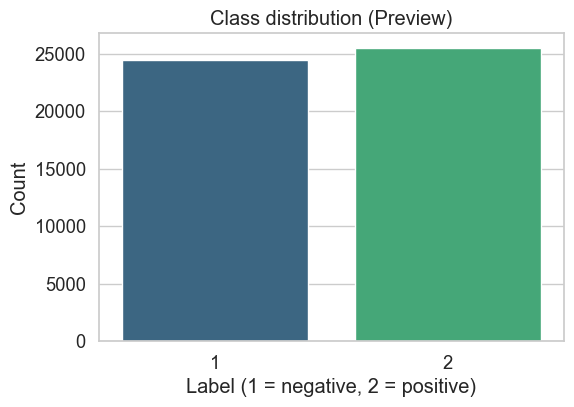

In [6]:
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class distribution (Preview)")
plt.xlabel("Label (1 = negative, 2 = positive)")
plt.ylabel("Count")
plt.show()

# Note: Well-balanced data

In [7]:
# Examplo negative
print("Negative examples:")
df_train_preview[df_train_preview.label == "1"].text.sample(5, random_state=42).tolist()

Negative examples:


['AVOID AT ALL COSTS: This is the not only the worst halloween but one of the worst horror movies in the world.This has nothing to do with the halloweens what so ever.Theres no michael he doesnt even exist in this world all he is in this movie is a killer from a horror movie that john carpenter created.Avoid this at all costs.The theme song goes like this "eight more days to halloween halloween halloween eight more days to halloween silver shamrock" this is sang by munchkins and goes by the tune from my fair lady.Do not listen to those idiots who gave this movie more than 1 star.The only reason to buy this or even watch this is if your a halloween series collector.',
 'I dissent. I thought it was tedious.: It just didn\'t hit the spot for me. I found the whole religious thing to be irrelevant. The exoctic mystical eastern religious fascination came across as being dated to me, a bit of a hippy/60s thing. And because of that, I was not really motivated to suspend my disbelief. It all se

In [8]:
# Exemplo positivo
print("Positive examples:")
df_train_preview[df_train_preview.label == "2"].text.sample(5, random_state=42).tolist()

Positive examples:


["Very Impressed By This: My son is only a couple of weeks old. He doesn't focus on much, but he does stare at this aquarium to my surprise.",
 'Great family Christmas movie: This movie is perfect for bringing the real spirit of Christmas in your home. Great music, fun retelling of the Nativity story.',
 'Great for 2 y.o. birthday: I purchased this for my son for his second birthday. It is great because he\'s very active and in a transitional stage with toys - too old for stuffed animals but too young conceptually for most toys with a recommended age of 3 and up. I have kept this for an indoor toy for the long winter months. Assembly was simple and at this point, I do not need to add the sand to the bottom to "weigh it down", but I might have to as he gets older and plays with the toy more aggressively. Most importantly, my son loves it - it keeps him happy, active and entertained. I hope your cherished little one will like it too.',
 'Great Story!: If you have ever lived in a small ru

# Next, we will understand:

- Size of reviews
- How outliers are they distributed?
- Discrepancies between negative/positive texts
- Is any pre-proc required?
- What sequence size use in the future? (for Transformers)

In [9]:
# Describe text legths
df_train_preview["length"] = df_train_preview["text"].apply(lambda x: len(x.split()))
df_train_preview["length_chars"] = df_train_preview["text"].apply(len)

df_train_preview[["length", "length_chars"]].describe()

,length,length_chars
count,50000.000000,50000.00000
mean,80.177580,441.01610
std,43.373988,240.64262
min,12.000000,101.00000
25%,44.000000,237.00000
50%,72.000000,394.00000
75%,111.000000,609.00000
max,241.000000,1015.00000


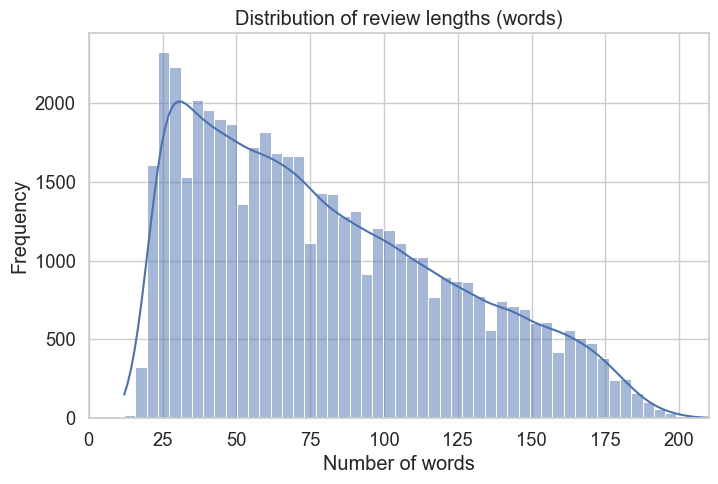

In [15]:
# Histograms
plt.figure(figsize=(8,5))
sns.histplot(df_train_preview["length"], bins=60, kde=True)
plt.title("Distribution of review lengths (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.xlim(0, 210)    # corta valores extremos
plt.show()

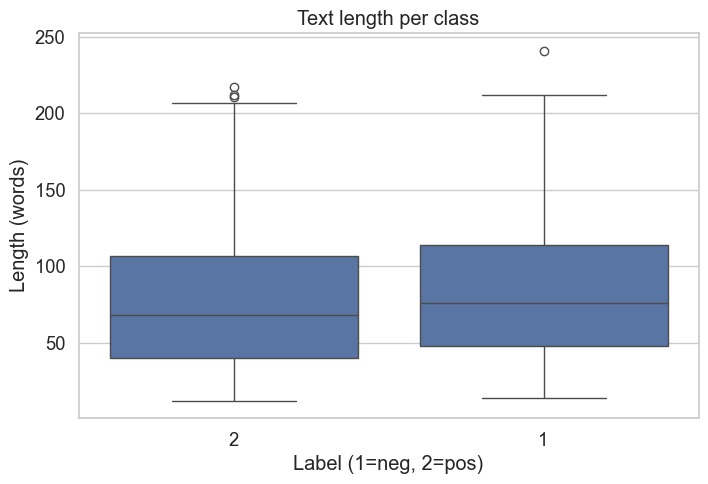

In [11]:
# Boxplots to assess outliers
plt.figure(figsize=(8,5))
sns.boxplot(data=df_train_preview, x="label", y="length")
plt.title("Text length per class")
plt.xlabel("Label (1=neg, 2=pos)")
plt.ylabel("Length (words)")
plt.show()

# note: Negative texts tend to be bigger 
# Very low number of outliers: facilitates pre-processing (truncation)

In [12]:
print("Shortest reviews:")
df_train_preview.nsmallest(5, "length")[["label","text","length"]]

Shortest reviews:


,label,text,length
41146,2,WHAT A BRILLIANT BOOK!!!!!!!!!!: This is soooo...,12
13223,2,Great Purchase: Installed in seconds. Great pe...,13
7654,2,Question of thought: How would Nietzsche criti...,14
8887,2,"First Knight (Cassette): Excellent service, pr...",14
16292,1,Bad Computer...Nice Screen: Bad Computer.........,14


In [13]:
print("Longest reviews:")
df_train_preview.nlargest(2, "length")[["label","text","length"]]

Longest reviews:


,label,text,length
44003,1,No: No no no no no no no no no no no no no no ...,241
44957,2,Great Prog. mix from the top rated DJ: Being a...,217


# Now, we move to the text cleanliness & normalization

- Lowercase
- Punctuation removal
- Numbers removal
- Multiple space removal
- Stopwords removal
- Contractions removal

In [38]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import contractions  # 

stopwords_en = set(ENGLISH_STOP_WORDS)

def clean_text(text):
    # 1. Expansão de contrações:
    text = contractions.fix(text)  # "don't" -> "do not"
    
    # 2. Lowercase
    text = text.lower()
    
    # 3. Remove punctuation
    text = re.sub(r"[^\w\s]", " ", text)
    
    # 4. Remove numbers
    text = re.sub(r"\b\d+\b", " ", text)
    
    # 5. Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

def remove_stopwords(text):
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_en and len(t) > 1]
    return " ".join(tokens)

df_train_preview["clean_text"] = df_train_preview["text"].apply(clean_text)
df_train_preview["clean_text_no_stop"] = df_train_preview["clean_text"].apply(remove_stopwords)
df_train_preview.head()

,label,text,length,length_chars,clean_text,clean_text_no_stop
0,2,Stuning even for the non-gamer: This sound tra...,80,426,stuning even for the non gamer this sound trac...,stuning non gamer sound track beautiful paints...
1,2,The best soundtrack ever to anything.: I'm rea...,97,509,the best soundtrack ever to anything i am read...,best soundtrack reading lot reviews saying bes...
2,2,Amazing!: This soundtrack is my favorite music...,129,760,amazing this soundtrack is my favorite music o...,amazing soundtrack favorite music time hands i...
3,2,Excellent Soundtrack: I truly like this soundt...,118,743,excellent soundtrack i truly like this soundtr...,excellent soundtrack truly like soundtrack enj...
4,2,"Remember, Pull Your Jaw Off The Floor After He...",87,481,remember pull your jaw off the floor after hea...,remember pull jaw floor hearing played game kn...


# Next, _Sentiment analysis + Word cloud + Vocabulary analysis_

In [39]:
from collections import Counter

def get_top_words(texts, n=20):
    counter = Counter()
    for t in texts:
        counter.update(t.split())
    return counter.most_common(n)

In [40]:
top_global = get_top_words(df_train_preview["clean_text_no_stop"], n=20)
top_global

[('book', 32998),
 ('movie', 15467),
 ('great', 15286),
 ('like', 15027),
 ('good', 14794),
 ('read', 13982),
 ('just', 13358),
 ('time', 10104),
 ('did', 9279),
 ('really', 8280),
 ('does', 7370),
 ('story', 7200),
 ('love', 7012),
 ('best', 6585),
 ('cd', 5887),
 ('better', 5851),
 ('buy', 5843),
 ('way', 5261),
 ('think', 5149),
 ('film', 5101)]

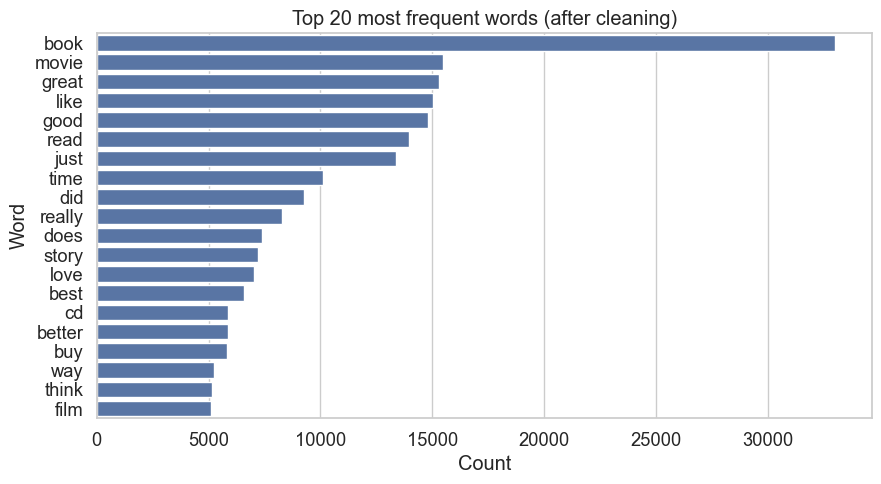

In [41]:
words, counts = zip(*top_global)

plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 20 most frequent words (after cleaning)")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

In [42]:
# top positives
top_pos = get_top_words(df_train_preview[df_train_preview.label=="2"]["clean_text_no_stop"], 20)
top_pos

[('book', 16777),
 ('great', 11695),
 ('good', 8642),
 ('read', 8111),
 ('movie', 7161),
 ('like', 7020),
 ('just', 5652),
 ('love', 5269),
 ('best', 4931),
 ('time', 4866),
 ('really', 4204),
 ('story', 4087),
 ('cd', 3734),
 ('album', 3305),
 ('did', 3165),
 ('does', 2920),
 ('music', 2875),
 ('little', 2736),
 ('think', 2631),
 ('way', 2590)]

In [43]:
# top negatives
top_neg = get_top_words(df_train_preview[df_train_preview.label=="1"]["clean_text_no_stop"], 20)
top_neg

[('book', 16221),
 ('movie', 8306),
 ('like', 8007),
 ('just', 7706),
 ('good', 6152),
 ('did', 6114),
 ('read', 5871),
 ('time', 5238),
 ('does', 4450),
 ('really', 4076),
 ('bad', 3685),
 ('buy', 3631),
 ('great', 3591),
 ('money', 3434),
 ('better', 3390),
 ('story', 3113),
 ('work', 2744),
 ('product', 2734),
 ('film', 2684),
 ('way', 2671)]

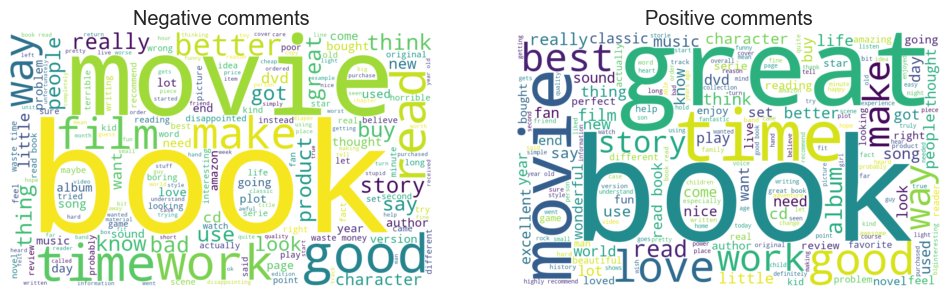

In [47]:
from wordcloud import WordCloud

text_all = " ".join(df_train_preview["clean_text_no_stop"])
text_neg = " ".join(df_train_preview[df_train_preview.label=="1"]["clean_text_no_stop"])
text_pos = " ".join(df_train_preview[df_train_preview.label=="2"]["clean_text_no_stop"])

wc_neg = WordCloud(width=1000, height=600, background_color="white").generate(text_neg)
wc_pos = WordCloud(width=1000, height=600, background_color="white").generate(text_pos)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,7))
ax1.imshow(wc_neg, interpolation="bilinear")
ax1.axis("off")
ax1.set_title("Negative comments")

ax2.imshow(wc_pos, interpolation="bilinear")
ax2.axis("off")
ax2.set_title("Positive comments")

plt.show()

In [50]:
pos_counts = Counter(" ".join(df_train_preview[df_train_preview.label=="2"]["clean_text_no_stop"]).split())
neg_counts = Counter(" ".join(df_train_preview[df_train_preview.label=="1"]["clean_text_no_stop"]).split())

# palavras que aparecem muito em um lado e pouco em outro
diff = {}

for w in set(pos_counts.keys()).union(neg_counts.keys()):
    diff[w] = pos_counts[w] - neg_counts[w]

# top palavras associadas a sentimento positivo
sorted(diff.items(), key=lambda x: -x[1])[:20]

[('great', 8104),
 ('love', 3526),
 ('best', 3277),
 ('good', 2490),
 ('read', 2240),
 ('excellent', 1862),
 ('album', 1659),
 ('cd', 1581),
 ('wonderful', 1387),
 ('easy', 1280),
 ('life', 1231),
 ('music', 1159),
 ('favorite', 1144),
 ('fun', 1111),
 ('recommend', 1056),
 ('amazing', 1049),
 ('highly', 1045),
 ('perfect', 1045),
 ('classic', 1023),
 ('loved', 981)]

In [51]:
sorted(diff.items(), key=lambda x: x[1])[:20]

[('did', -2949),
 ('money', -2757),
 ('bad', -2718),
 ('waste', -2290),
 ('just', -2054),
 ('boring', -1885),
 ('worst', -1709),
 ('does', -1530),
 ('disappointed', -1513),
 ('buy', -1419),
 ('poor', -1394),
 ('movie', -1145),
 ('horrible', -1090),
 ('terrible', -1080),
 ('like', -987),
 ('product', -945),
 ('better', -929),
 ('instead', -855),
 ('plot', -831),
 ('disappointing', -786)]

# Words make sense! 

# Now, let's vectorize TF-IDF and train a simple logistic regression just to check how things will behave > 
# In notebook **03_sentiment_modeling.ipynb**, we will work more on this.

In [53]:
from sklearn.model_selection import train_test_split

X = df_train_preview["clean_text_no_stop"].values
y = df_train_preview["label"].astype(int).values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_val)

(40000, 10000)

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=50000,       # suficiente por ora
    ngram_range=(1,2),        # unigrams + bigrams
    min_df=5,                 # remove palavras muito raras
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)

X_train_tfidf.shape, X_val_tfidf.shape

((40000, 42733), (10000, 42733))

In [55]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=200,
    n_jobs=-1,
    C=2.0,                  # leve regularização
)

clf.fit(X_train_tfidf, y_train)

LogisticRegression(C=2.0, max_iter=200, n_jobs=-1)

In [56]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = clf.predict(X_val_tfidf)

acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", acc)

Validation Accuracy: 0.8894


In [57]:
# relatorio completo
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.89      0.88      0.89      4899
           2       0.89      0.90      0.89      5101

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



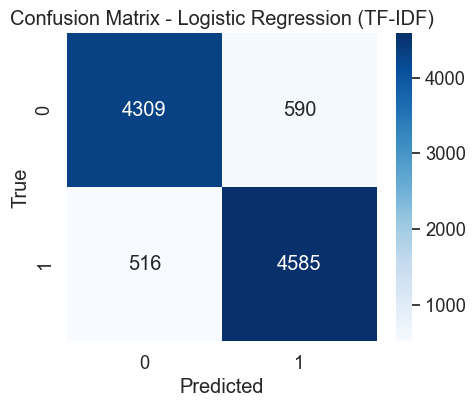

In [58]:
# matriz de confusao
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Results show an interesting baseline. This notebook ends here. 